In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

# 1. Show that when correctly viewed, the points generated from `test_broken_libc.py` lie on a set of planes

When I orient a 3D plot of the data, distinct planes can be seen - ~ 6 per vertical grid square. This implies that the numbers generated using this routine can only lie on certain planes in each axis. 

<IPython.core.display.Javascript object>


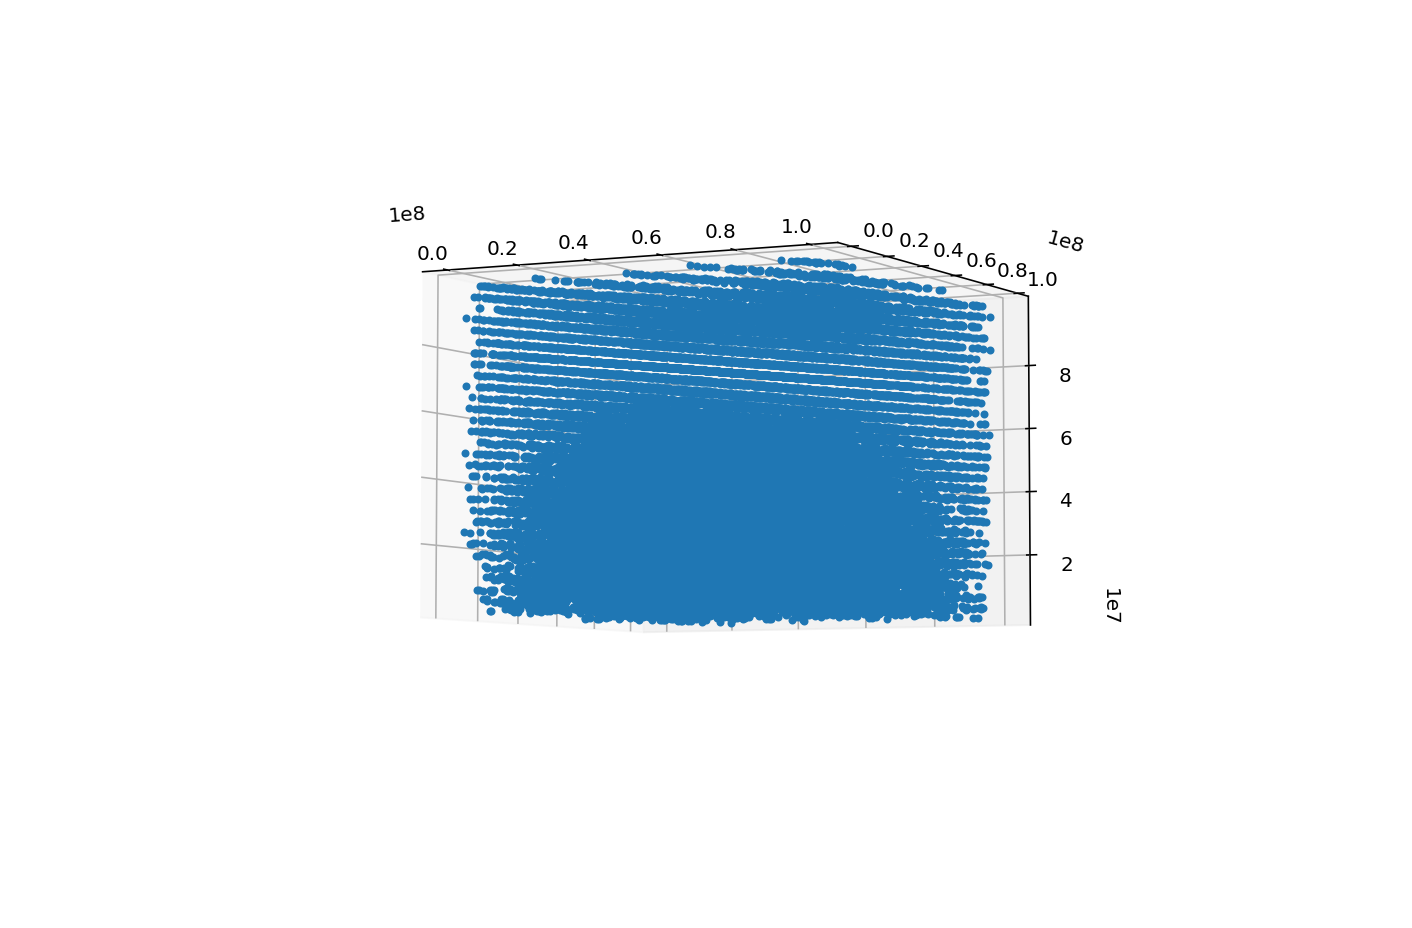

In [16]:
x,y,z = np.genfromtxt('rand_points.txt',unpack=True)
%matplotlib notebook
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(x,y,z,marker='.',ls='')
plt.show()

### Do you see the same effect in python?

Here I'll use python's `np.random.rand` and use the same code to make the triplets as in Jon's call's to the C function.

Below you can see that I've plotted a similar angle to above, and even with a lower density of points (so that it would run in a reasonable amount of time), there is a density that appears randomly distributed such that you can't see any planes (or any structure/geometry for the gaps between points) in the plot.

In [5]:
n=300000
vec=np.random.rand(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

In [6]:
x_py = vv2[:,0]
y_py = vv2[:,1]
z_py = vv2[:,2]

<IPython.core.display.Javascript object>


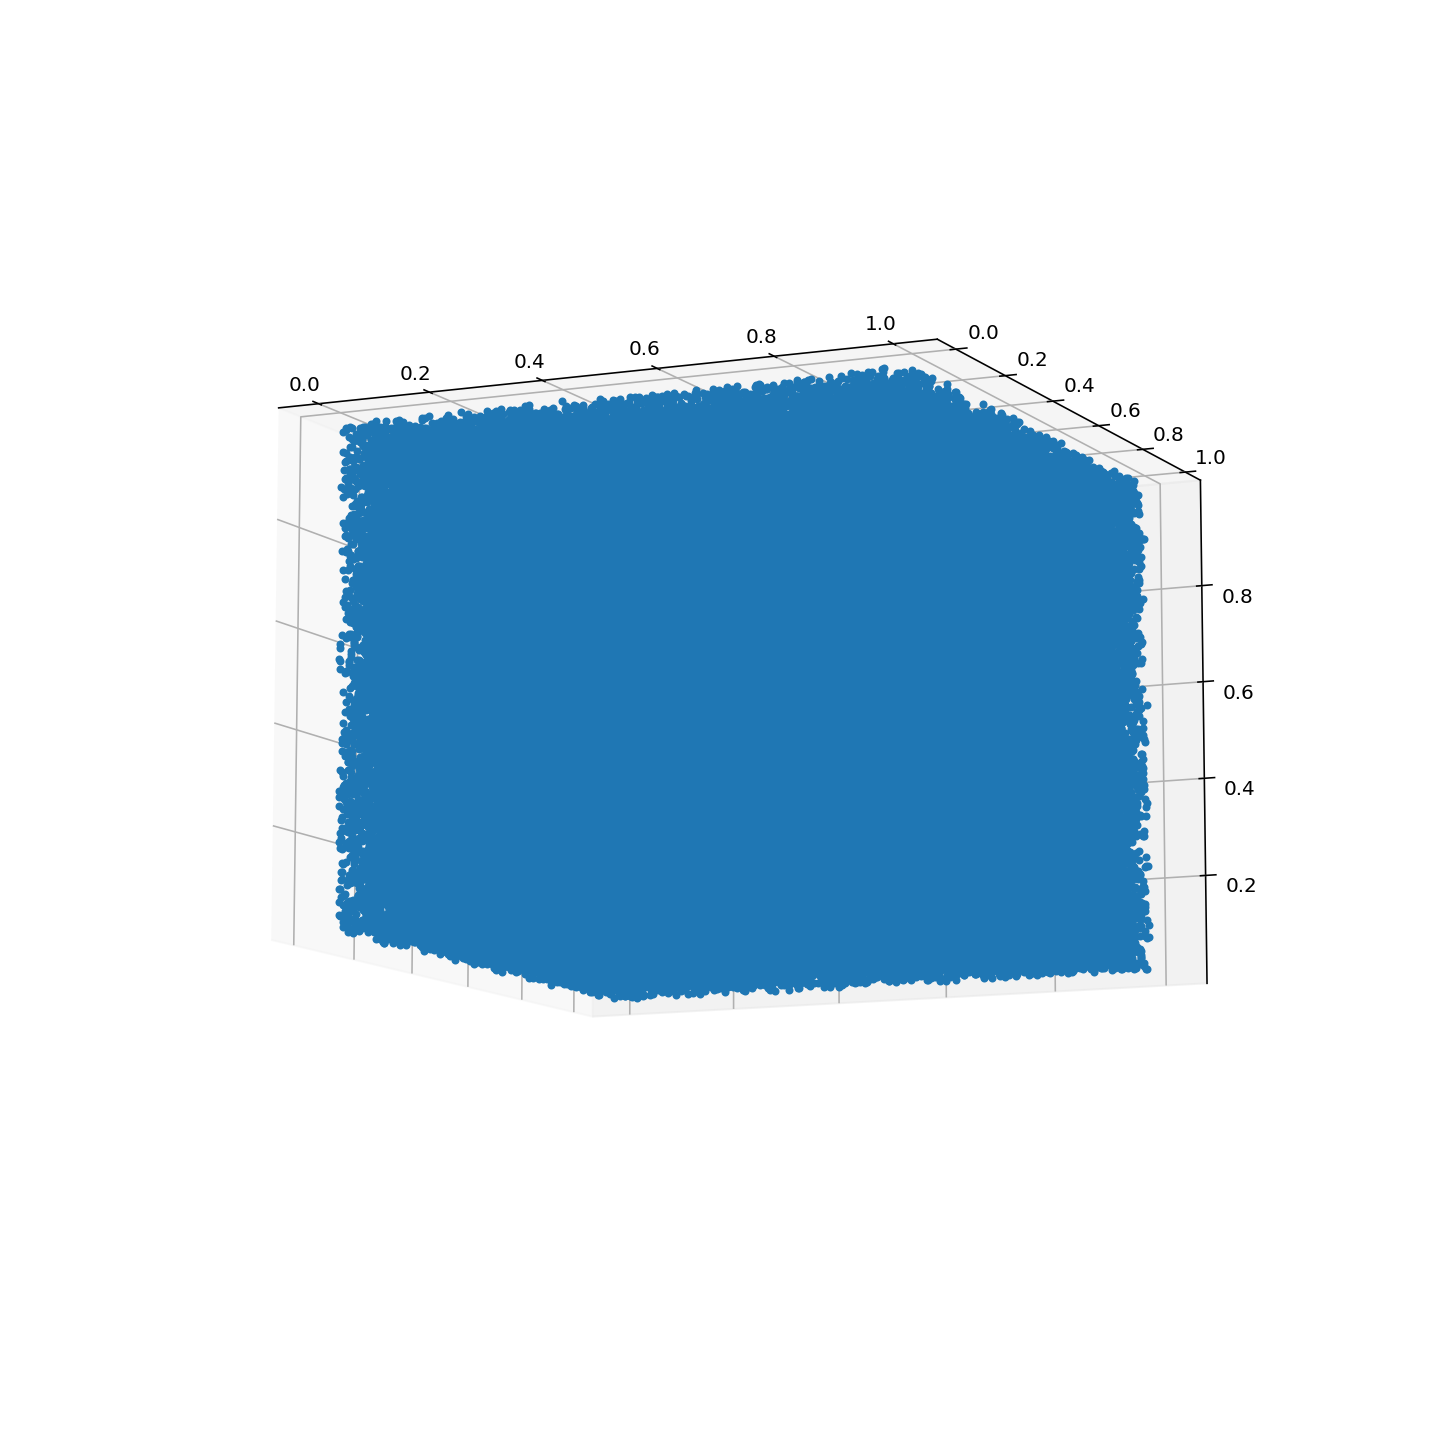

In [7]:
%matplotlib notebook
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(x_py,y_py,z_py,marker='.',ls='')
plt.show()

I couldn't find the random number generator on my local machine - I have an old Mac and I've messed with a bunch of libraries to do other things

# 2. Write a rejection method to generate exponential deviates from another distribution

Let's plot our exponential with the three suggested bounding functions to see which works best

/var/folders/dg/7jl6bkpj645c5wgdkkh7h8zw0000gn/T/ipykernel_28657/3892567066.py:3: RuntimeWarning: divide by zero encountered in power
  power=x**(-1.1)


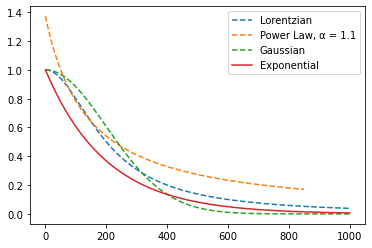

In [110]:
x = np.linspace(0,5,1001)
lorentz = 1/(1+x**2)
power=x**(-1.1)
exp = np.exp(-x)
gauss = np.exp(-0.5*x**2)
plt.plot(lorentz,'--',label='Lorentzian')
plt.plot(power[150:],'--',label='Power Law, α = 1.1') #bound power law to a range where it has decayed enough to be ~ the same magnitude as other plots
plt.plot(gauss,'--',label='Gaussian')
plt.plot(exp,label='Exponential')
plt.legend()

We can see that either a Lorentzian or power law will work as a bounding distribution. The Gaussian drops below the exponential function at x > 400, so this wouldn't be a good option. I'll be using a Lorentzian because I find it easier to deal with than a power law.

### Calculate deviates

#### Exponential Function:

PDF: $P(x) = e^{-x}$

CDF: $CDF = \int_{0}^{\infty} P(x) dx = \int_{0}^{\infty} e^{-x} dx = 1$

#### Bounding (Lorentzian) Function:
PDF: $P(x) = \frac{1}{1+x^2}$

CDF: $CDF = \int_{0}^{\infty} \frac{1}{1+x^2} = -\frac{\pi}{2} \rightarrow$ we want this to be 1

$\Rightarrow$ normalized CDF is $\frac{arctan(x)}{\pi} + \frac{1}{2} \Rightarrow x = tan(\pi(x-1/2)) \rightarrow$ these are the Lorentzian deviates

We accept the random number if it is less than the ratio of PDFs: $\frac{e^{-dev}}{\frac{1}{1+dev^2}}$

We can see below that the acceptance rate is 81%

In [3]:
%matplotlib inline
x = np.linspace(0,100)

def lorentz(x):
    return 1/(1+x**2)

/var/folders/dg/7jl6bkpj645c5wgdkkh7h8zw0000gn/T/ipykernel_4564/3331356975.py:4: RuntimeWarning: overflow encountered in exp
  accept = np.random.rand(n) < np.exp(-lorentz_dev)/lorentz(lorentz_dev) #ratio of pdfs
/var/folders/dg/7jl6bkpj645c5wgdkkh7h8zw0000gn/T/ipykernel_4564/3331356975.py:4: RuntimeWarning: overflow encountered in true_divide
  accept = np.random.rand(n) < np.exp(-lorentz_dev)/lorentz(lorentz_dev) #ratio of pdfs


Acceptance fraction: 0.818704


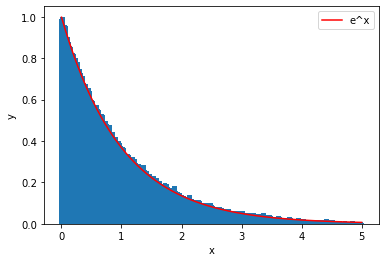

In [4]:
def exp_from_lorentz(n):
    r = np.random.rand(n)
    lorentz_dev = np.tan(np.pi*(r-0.5))
    accept = np.random.rand(n) < np.exp(-lorentz_dev)/lorentz(lorentz_dev) #ratio of pdfs
    frac = len(lorentz_dev[accept])/len(lorentz_dev)
    return lorentz_dev[accept],frac

n = 1000000
y = exp_from_lorentz(n)[0]
frac_accepted = exp_from_lorentz(n)[1]
print(f'Acceptance fraction: {frac_accepted}')

counts,bins = np.histogram(y,np.linspace(0,5,1001))
bb=0.5*(bins[1:]+bins[:-1])
plt.bar(bb,counts/counts.max(),0.07) #normalize counts
plt.plot(bb,np.exp(-bb),'r',label='e^x')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

# 3. Repeat problem 2 using a ratio of uniforms

1. Take a (u,v) plane where $ 0 < u < \sqrt{P(v/u)}$

    $P = e^{-x} \Rightarrow u = \sqrt{e^{-u/v}} = e^{-v/2u}$

    $\Rightarrow v = -2u\ ln(u),\ where\ 0 < u < 1$
    
    Because v is a $ln$ expression, it is also always > 0
  

2. Sample u,v randomly in this region (using `np.random.rand`)

    Note that v is normalized by max(v)


3. Return v/u and accept if it is smaller than $\sqrt{P}$

The following code is adapted from Jon's `ratio_uniforms_gaussian.py`.

See below that the histogram looks a lot like the exponential function. The acceptance rate here is 84%, which is a few % higher than the rejection method.

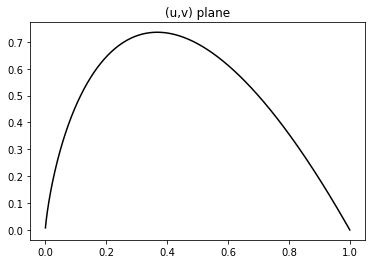

/var/folders/dg/7jl6bkpj645c5wgdkkh7h8zw0000gn/T/ipykernel_28657/494303817.py:15: RuntimeWarning: overflow encountered in exp
  accept=u<np.sqrt(np.exp(-r))


Acceptance fraction: 0.839733


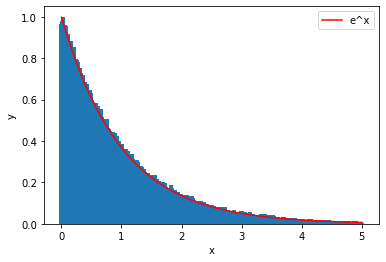

In [205]:
u = np.linspace(0,1,2001)
u = u[1:]
v = -2*u*np.log(u)

plt.plot(u,v,'k')
plt.title('(u,v) plane')
plt.show()

N = 1000000
u = np.random.rand(N)
v = (np.random.rand(N)*2-1)*v.max()

r = v/u

accept=u<np.sqrt(np.exp(-r))
exp=r[accept]

accept_frac = len(exp)/len(r)

print(f'Acceptance fraction: {accept_frac}')

counts,bins = np.histogram(exp,np.linspace(0,5,1001))
bb=0.5*(bins[1:]+bins[:-1])
plt.bar(bb,counts/counts.max(),0.07) #normalize counts
plt.plot(bb,np.exp(-bb),'r',label='e^x')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()